Training baseline


/tmp/ipykernel_339235/1378712895.py:115: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device.type == 'cuda')
/tmp/ipykernel_339235/1378712895.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == 'cuda'):


Ep 001/200  loss=4.1919  lr=2.0e-04
Ep 002/200  loss=3.7843  lr=3.0e-04
Ep 003/200  loss=3.5163  lr=4.0e-04
Ep 004/200  loss=3.2755  lr=5.0e-04
Ep 005/200  loss=3.0984  lr=5.0e-04
Ep 006/200  loss=2.9287  lr=5.0e-04
Ep 007/200  loss=2.7874  lr=5.0e-04
Ep 008/200  loss=2.6633  lr=5.0e-04
Ep 009/200  loss=2.5611  lr=5.0e-04
Ep 010/200  loss=2.4464  lr=5.0e-04
Ep 020/200  loss=1.7617  lr=4.9e-04
Ep 040/200  loss=1.0583  lr=4.6e-04
Ep 060/200  loss=0.6739  lr=4.1e-04
Ep 080/200  loss=0.4535  lr=3.4e-04
Ep 100/200  loss=0.3055  lr=2.6e-04
Ep 120/200  loss=0.2126  lr=1.8e-04
Ep 140/200  loss=0.1495  lr=1.1e-04
Ep 160/200  loss=0.1001  lr=5.5e-05
Ep 180/200  loss=0.0793  lr=1.8e-05
Ep 200/200  loss=0.0721  lr=5.0e-06
Training rollout
Ep 001/200  loss=4.1647  lr=2.0e-04
Ep 002/200  loss=3.7309  lr=3.0e-04
Ep 003/200  loss=3.4143  lr=4.0e-04
Ep 004/200  loss=3.1700  lr=5.0e-04
Ep 005/200  loss=2.9994  lr=5.0e-04
Ep 006/200  loss=2.8264  lr=5.0e-04
Ep 007/200  loss=2.6849  lr=5.0e-04
Ep 008/200 

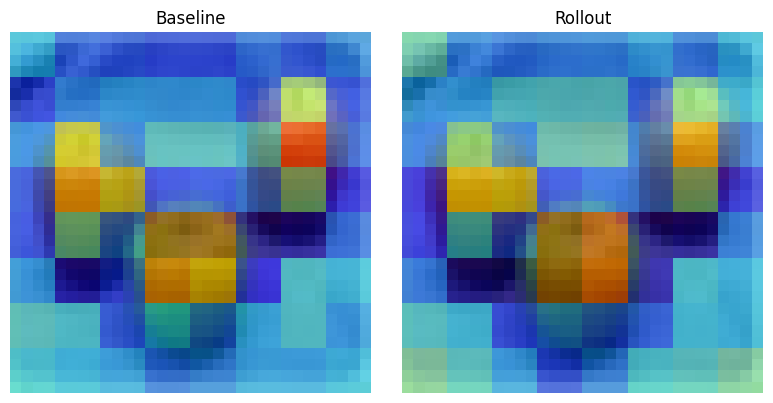

In [ ]:
import json, math, random, pathlib, argparse, time
from typing import List, Tuple

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as T

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

class ViTBlock(nn.Module):
    def __init__(self, embed_dim, heads, mlp_ratio=4.0, p=0.1):
        super().__init__()
        self.n1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, heads, dropout=p, batch_first=True)
        self.d1 = nn.Dropout(p)
        self.n2 = nn.LayerNorm(embed_dim)
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(hidden, embed_dim),
            nn.Dropout(p),
        )
    def forward(self, x, need_attn=False):
        y, w = self.attn(self.n1(x), self.n1(x), self.n1(x),
                         need_weights=need_attn, average_attn_weights=not need_attn)
        x = x + self.d1(y)
        x = x + self.mlp(self.n2(x))
        return (x, w) if need_attn else x


class ViT(nn.Module):
    def __init__(self, image_size=32, patch=4, classes=100, embed=128,
                 depth=6, heads=4, p=0.1, mode='baseline'):
        super().__init__()
        self.mode = mode
        n_patches = (image_size // patch) ** 2
        self.patch = nn.Conv2d(3, embed, patch, patch)
        self.cls  = nn.Parameter(torch.zeros(1, 1, embed))
        self.pos  = nn.Parameter(torch.zeros(1, n_patches + 1, embed))
        self.drop = nn.Dropout(p)
        self.blocks = nn.ModuleList([ViTBlock(embed, heads, p=p) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed)
        self.head = nn.Linear(embed, classes)
        nn.init.trunc_normal_(self.pos, std=0.02)
        nn.init.trunc_normal_(self.cls, std=0.02)

    def _embed(self, x):
        B = x.size(0)
        x = self.patch(x).flatten(2).transpose(1, 2)
        x = torch.cat([self.cls.expand(B, -1, -1), x], 1)
        return self.drop(x + self.pos[:, :x.size(1)])

    @staticmethod
    def _rollout(attn):
        B, H, S, _ = attn[0].shape
        eye = torch.eye(S, device=attn[0].device).expand(B, S, S)
        P = eye
        for A in attn:
            A = A.mean(1) + eye
            A = A / A.sum(-1, keepdim=True)
            P = torch.bmm(A, P)
        return P

    def forward_features(self, x):
        x = self._embed(x)
        attn = []
        for blk in self.blocks:
            if self.mode == 'rollout':
                x, w = blk(x, need_attn=True); attn.append(w.detach())
            else:
                x = blk(x)
        x = self.norm(x)
        if self.mode == 'baseline':
            return x[:, 0]
        P = self._rollout(attn)
        W = P[:, 0, 1:] / P[:, 0, 1:].sum(-1, keepdim=True)
        patches = x[:, 1:, :]
        return (W.unsqueeze(-1) * patches).sum(1)

    def forward(self, x):
        return self.head(self.forward_features(x))

def get_loaders(batch=128):
    mean, std = (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)
    train_tf = T.Compose([T.RandomCrop(32, 4), T.RandomHorizontalFlip(),
                          T.ToTensor(), T.Normalize(mean, std)])
    test_tf  = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    root = './data'
    train_ds = torchvision.datasets.CIFAR100(root, True,  download=True, transform=train_tf)
    test_ds  = torchvision.datasets.CIFAR100(root, False, download=True, transform=test_tf)
    return (DataLoader(train_ds, batch_size=batch, shuffle=True,  num_workers=4),
            DataLoader(test_ds,  batch_size=batch, shuffle=False, num_workers=4),
            test_ds)

def train(model, loader, epochs, device, lr_max=5e-4, lr_min=5e-6, warm=5, wd=1e-4):
    opt = torch.optim.AdamW(model.parameters(), lr=lr_max, weight_decay=wd)
    def lr_lambda(ep):
        if ep < warm:
            return (ep + 1) / warm
        t = (ep - warm) / (epochs - warm)
        cosine = 0.5 * (1 + math.cos(math.pi * t))
        return (lr_min / lr_max) + (1 - lr_min / lr_max) * cosine
    sched = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
    crit = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=device.type == 'cuda')
    model.train()
    for ep in range(epochs):
        tot = 0
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=device.type == 'cuda'):
                loss = crit(model(imgs), lbls)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            tot += loss.item()
        sched.step()
        if (ep + 1) % 20 == 0 or ep < 10:
            print(f"Ep {ep+1:03}/{epochs}  loss={tot/len(loader):.4f}  lr={opt.param_groups[0]['lr']:.1e}")

def collect_feats(model, ds, classes, per_cls, device):
    id_map = {c: ds.class_to_idx[c] for c in classes}
    chosen, labs, per = [], [], {c: 0 for c in classes}
    for i, (_, y) in enumerate(ds):
        for c, cid in id_map.items():
            if y == cid and per[c] < per_cls:
                chosen.append(i); labs.append(cid); per[c] += 1
        if all(v >= per_cls for v in per.values()): break
    loader = DataLoader(Subset(ds, chosen), batch_size=256, shuffle=False)
    model.eval(); feats = []
    with torch.no_grad():
        for imgs, _ in loader:
            feats.append(model.forward_features(imgs.to(device)).cpu())
    return torch.cat(feats), torch.tensor(labs)

def knn_acc(x, y, k=5):
    knn = KNeighborsClassifier(k, metric='cosine'); knn.fit(x, y)
    return knn.score(x, y)

def centroid_stats(x, y):
    x = F.normalize(x, p=2, dim=1)            # <-- new: L2 normalise
    cls = y.unique()
    cent = torch.stack([x[y == c].mean(0) for c in cls])
    intra = torch.stack([F.pairwise_distance(x[y == c], cent[i]).mean()
                         for i, c in enumerate(cls)]).mean().item()
    cos = 1 - F.cosine_similarity(cent.unsqueeze(1), cent.unsqueeze(0), -1)
    inter = cos[~torch.eye(len(cls), dtype=bool)].mean().item()
    return intra, inter, inter / intra

def patch_heatmap(model, img_t, device, up=4):
    model.eval()
    with torch.no_grad():
        emb = model._embed(img_t.unsqueeze(0).to(device))
        attn = [blk(emb, True)[1] for blk in model.blocks]
    W = model._rollout(attn)[0, 0, 1:].cpu().numpy()
    p = int(math.sqrt(W.size)); heat = W.reshape(p, p)
    heat = np.kron(heat, np.ones((up, up)))
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-6)
    return heat

def overlay(img_t, heat, alpha=.5):
    img = img_t.permute(1, 2, 0).cpu().numpy()
    img = img * np.array([0.2673,0.2564,0.2762]) + np.array([0.5071,0.4865,0.4409])
    plt.imshow(np.clip(img,0,1)); plt.imshow(heat, cmap='jet', alpha=alpha); plt.axis('off')

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=200)
    parser.add_argument('--warm',   type=int, default=5)
    parser.add_argument('--lr',     type=float, default=5e-4)
    parser.add_argument('--lr_min', type=float, default=5e-6)
    parser.add_argument('--retrain', action='store_true')
    parser.add_argument('--per_class', type=int, default=100)
    parser.add_argument('--classes', nargs='*', default=None)
    args = parser.parse_args([])  

    train_dl, test_dl, test_ds = get_loaders()
    if args.classes is None: args.classes = test_ds.classes[:10]  
    dev = torch.device('cuda' if torch.cuda.is_available()
             else 'mps' if torch.backends.mps.is_available() else 'cpu')

    def build(mode): return ViT(mode=mode).to(dev)
    baseline, rollout = build('baseline'), build('rollout')

    if args.retrain or not pathlib.Path('baseline.pth').exists():
        print('Training baseline'); train(baseline, train_dl, args.epochs, dev,
                                         args.lr, args.lr_min, args.warm)
        torch.save(baseline.state_dict(), 'baseline.pth')
    else: baseline.load_state_dict(torch.load('baseline.pth', map_location=dev))

    if args.retrain or not pathlib.Path('rollout.pth').exists():
        print('Training rollout'); train(rollout, train_dl, args.epochs, dev,
                                         args.lr, args.lr_min, args.warm)
        torch.save(rollout.state_dict(), 'rollout.pth')
    else: rollout.load_state_dict(torch.load('rollout.pth', map_location=dev))

    metrics = {}
    for name, model in [('baseline', baseline), ('rollout', rollout)]:
        x, y = collect_feats(model, test_ds, args.classes, args.per_class, dev)
        intra, inter, ratio = centroid_stats(x, y)
        acc = knn_acc(F.normalize(x,2,1), y)       
        sil = silhouette_score(x.numpy(), y.numpy(), metric='euclidean')
        metrics[name] = {k: float(v) for k, v in
                         dict(intra=intra, inter=inter, ratio=ratio,
                              knn5=acc, silhouette=sil).items()}
        print(f"{name:8s}  intra={intra:.4f}  inter={inter:.4f}  "
              f"ratio={ratio:.2f}  kNN5={acc:.3f}  sil={sil:.3f}")

    with open('results.json', 'w') as fp:
        json.dump(metrics, fp, indent=2)

    cid = test_ds.class_to_idx[args.classes[0]]
    idx = next(i for i, (_, y) in enumerate(test_ds) if y == cid)
    img_t, _ = test_ds[idx]
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); overlay(img_t, patch_heatmap(baseline,img_t,dev)); plt.title('Baseline')
    plt.subplot(1,2,2); overlay(img_t, patch_heatmap(rollout, img_t, dev)); plt.title('Rollout')
    plt.tight_layout(); plt.savefig('heatmap_compare.png', dpi=200)
    print('Saved results.json and heatmap_compare.png')

if __name__ == '__main__':
    main()


In [ ]:
import torch, torchvision, argparse, json, math, pathlib
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score

def main():
    train_dl, test_dl, test_ds = get_loaders()             
    device = torch.device('cuda' if torch.cuda.is_available()
                          else 'mps' if torch.backends.mps.is_available() else 'cpu')
    baseline = ViT(mode='baseline').to(device)
    rollout  = ViT(mode='rollout').to(device)
    baseline.load_state_dict(torch.load('baseline.pth', map_location=device))
    rollout.load_state_dict(torch.load('rollout.pth',  map_location=device))

    classes = test_ds.classes            
    per_cls = 100                        

    metrics = {}
    for name, model in [('baseline', baseline), ('rollout', rollout)]:
        feats, labels = collect_feats(model, test_ds, classes, per_cls, device)
        feats = F.normalize(feats, 2, 1)                
        intra, inter, ratio = centroid_stats(feats, labels)
        acc = KNeighborsClassifier(5, metric='cosine').fit(feats, labels).score(feats, labels)
        sil = silhouette_score(feats.numpy(), labels.numpy(), metric='euclidean')
        metrics[name] = {k: float(v) for k, v in
                         dict(intra=intra, inter=inter, ratio=ratio,
                              knn5=acc, silhouette=sil).items()}
        print(f"{name:8s}  knn5={acc:.3f}  intra={intra:.4f}  "
              f"inter={inter:.4f}  ratio={ratio:.2f}  sil={sil:.3f}")

    with open('results_100.json', 'w') as fp:
        json.dump(metrics, fp, indent=2)

if __name__ == '__main__':
    main()


baseline  knn5=0.616  intra=0.8593  inter=0.8614  ratio=1.00  sil=0.003
rollout   knn5=0.588  intra=0.8830  inter=0.9560  ratio=1.08  sil=-0.000
